Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.3491 - loss: 2.1220 - val_accuracy: 0.5308 - val_loss: 1.3687 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.5795 - loss: 1.2101 - val_accuracy: 0.6823 - val_loss: 0.9141 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.6665 - loss: 0.9479 - val_accuracy: 0.6908 - val_loss: 0.9003 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.7119 - loss: 0.8272 - val_accuracy: 0.7578 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.7388 - loss: 0.7437 - val_accuracy: 0.7204 - val_loss: 0.8862 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.7683 - loss: 0.6794 - val_accuracy: 0.7806 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.7795 - l

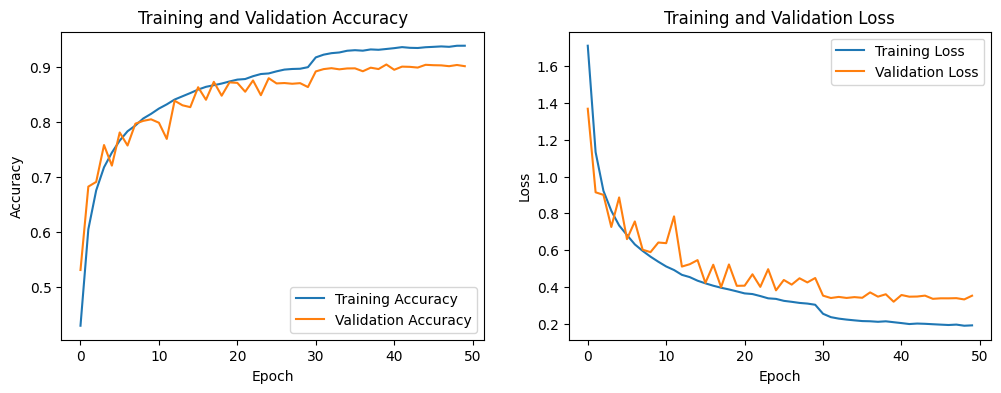


Classification Report:

              precision    recall  f1-score   support

    Airplane     0.9159    0.9150    0.9155      1000
  Automobile     0.9405    0.9640    0.9521      1000
        Bird     0.8950    0.8520    0.8730      1000
         Cat     0.8418    0.7770    0.8081      1000
        Deer     0.8974    0.9100    0.9037      1000
         Dog     0.8728    0.8300    0.8508      1000
        Frog     0.8810    0.9550    0.9165      1000
       Horse     0.9239    0.9470    0.9353      1000
        Ship     0.9458    0.9420    0.9439      1000
       Truck     0.9205    0.9490    0.9345      1000

    accuracy                         0.9041     10000
   macro avg     0.9035    0.9041    0.9033     10000
weighted avg     0.9035    0.9041    0.9033     10000



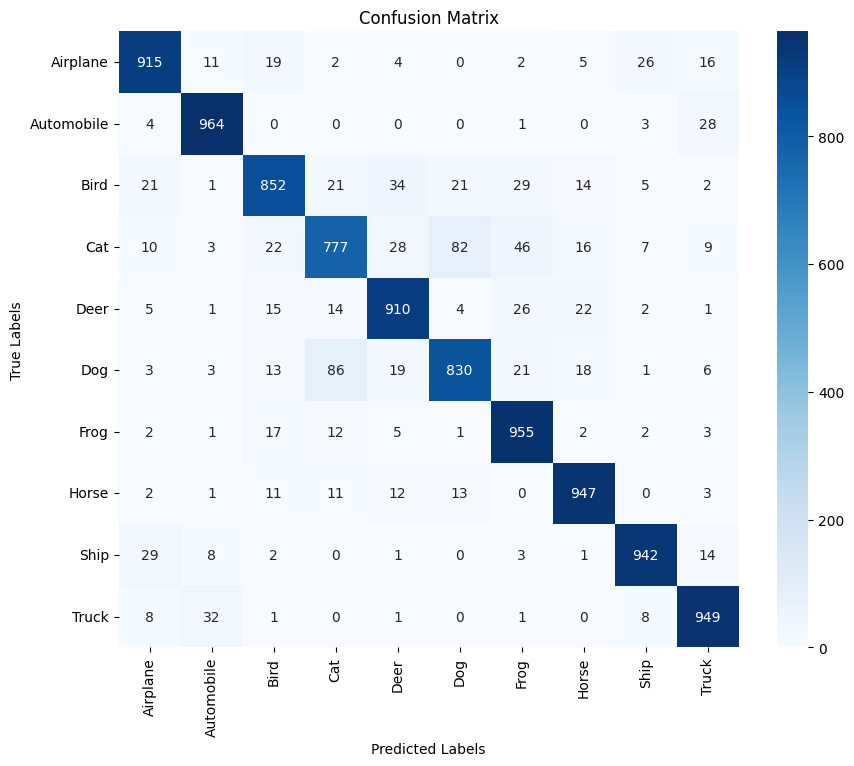

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load and Preprocess the Data
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize the images to have mean 0 and standard deviation 1
mean = train_images.mean(axis=(0,1,2), keepdims=True)
std = train_images.std(axis=(0,1,2), keepdims=True)
train_images = (train_images - mean) / std
test_images = (test_images - mean) / std

# Step 2: Data Augmentation
# Define data augmentation pipeline using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(train_images)

# Step 3: Define the Model Architecture
# Build a convolutional neural network (CNN) using Keras Sequential API
model = models.Sequential()
weight_decay = 1e-6

# Convolutional Block 1
model.add(layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                             input_shape=(32,32,3)))             # First convolutional layer
model.add(BatchNormalization())
model.add(layers.Activation('relu'))                             # Apply ReLU activation
model.add(layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))                  # Down-sample the feature maps
model.add(Dropout(0.2))                                          # Regularization using Dropout

# Convolutional Block 2
model.add(layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Convolutional Block 3
model.add(layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Fully Connected Layers
model.add(layers.Flatten())                                      # Flatten the 3D feature maps into 1D vector
model.add(layers.Dense(10))                                      # Output layer with 10 units for 10 classes

# Step 4: Compile the Model
# Define optimizer and compile the model
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

# Step 5: Define Callbacks
# Learning rate scheduler to adjust the learning rate during training
def lr_scheduler(epoch):
    if epoch < 30:
        return 0.001
    else:
        return 0.0001
lr_callback = LearningRateScheduler(lr_scheduler)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

# Step 6: Train the Model
# Train the model using augmented data and defined callbacks
history = model.fit(datagen.flow(train_images, train_labels, batch_size=100),
                              epochs=50,
                              validation_data=(test_images, test_labels),
                              callbacks=[lr_callback, early_stopping])

# Step 7: Evaluate the Model
# Evaluate the trained model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict on the test dataset
y_pred_logits = model.predict(test_images)
y_pred = np.argmax(y_pred_logits, axis=1)  # Convert logits to class predictions
y_true = test_labels.flatten()             # Flatten true labels for evaluation

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Step 8: Compute Metrics
# Generate a classification report
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred, target_names=[
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
], digits=4)
print("\nClassification Report:\n")
print(report)

# Step 9: Visualize the Confusion Matrix
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
], yticklabels=[
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
